#  Young and Old Stellar populations:  MIRISim (Imager)

#### This notebook replicated the MIRI Imager part of the 1 Zw 18: Dust Life Cycle at Very Low Metallicity JWST GTO programme (#1233). 

Details of the APT file used in this example science program can be found https://jwst.stsci.edu/observing-programs/program-information?id=1233

**Science Objective:** 
The main science goals of this project is to characterize metal-poor resolved stellar populations in a dwarf irregular galaxy at a distance of 18 Mpc. The galaxy 1 Zw 18 is a starburst galaxy and contains populations of both young and old stars both of which are surrounded by circumstellar dust and are bright in the mid-IR. The MIRI colours of young stellar objects (YSOs) and evolved stars (AGB stars and planetary nebulae) have been estimated by Jones at al 2017a; this work was used to select the MIRI filters for this GTO programme and in the MIRI Simulation. 

**In this notebook**, we create a scene with a mixture of dusty and non dust point sources placed at random locations within the imager field of view, and run through a MIRISim simulation showing the products created at each stage. The dusty sources include a mixture of Carbon stars, M-type stars, and young stellar objects (YSOs). The other point sources in 1 Zw 18 are represented by a randomized mixture of stellar photospheres.  

**NOTE** this notebook must be started within  the correct anaconda environment in which you have MIRISim installed. This is a prerequisite for using MIRISim, and installation instructions can be found [here](http://miri.ster.kuleuven.be/bin/view/Public/MiricleInstallation).

When launching the notebook, make sure in the right Anaconda environment. i.e. type

<code> source activate miricle </code> 

in the terminal before starting the notebook.

### Steps in this notebook:

0. Import useful python packages
1. Create a Scene
2. Initialise the simulation parameters
3. Run the simulation
4. Examine some of the outputs.   

## Step 0 - Some general python housekeeping
### Import useful python packages

In [1]:
# Import usefull python packages
import numpy as np
import glob                 # glob is used to find the output directory
import os                   # for listing directory contents
from astropy.io import fits # for reading FITS file contents

# Import python packages used to display images inline in the notebook
import matplotlib.pyplot as plt    
from matplotlib import colors,cm
%matplotlib inline       

######################################
# Now import MIRISim specific packages 

# import the configuration file parsers so they can be written to file
from mirisim.config_parser import SimConfig, SimulatorConfig, SceneConfig

# import scene component generators
from mirisim.skysim import Background, sed, Point, Galaxy, kinetics, ExternalSed
from mirisim.skysim import wrap_pysynphot as wS

from mirisim import MiriSimulation         

### Define some common functions 

1) <code>save_to_fits</code> - Used to save the generated scene to a fits file

2) <code>show_outputs</code> - Used in plotting outputs from MIRISim

3) <code>row_based_idx</code> - Used to fill matplotlib subplots by column, not row

4) <code>show_skycubes_spec</code> - Used to plot the spectrum in datacubes generated by MIRISim

In [2]:
def save_to_fits(scene, light_path, filename='MIRISim_scene.fits', SpatialSampling=0.1, WavelengthRange=None, 
                 WavelengthSampling=0.01):
    """
    Function to save the MIRISim scene to a fits file.
    
    :param filename: Name of file to save - default is "MIRISim_scene.fits"
    :type filename: string       
    
    :param SpatialSampling: Spatial sampling (in arcsec) - default is 0.1 arcseconds
    :type SpatialSampling: float
    
    :param WavelengthRange: Wavelength range to process (in microns) - default is [5, 28] microns
    :type WavelengthRange: array
    
    :param WavelengthSampling: Channel width (in microns) - default is 0.1 arcseconds
    :type WavelengthSampling: float
    
    :rtype: None
    :raises Exception: when light_path parameter not set to MRS or IMA
    """
    
    # Avoids array being extended inside function for mutliple calls. Python gotcha
    if WavelengthRange is None:
        WavelengthRange = [5, 28]
        
    if light_path == 'IMA':
        # IMA Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-57., 57.],[-57., 57.]])   
    elif light_path == "MRS":
        # MRS Field of view [xmin,xmax],[ymin,ymax] [arcsec]
        FOV = np.array([[-4., 4.],[-4., 4.]])       
    else:
        raise Exception('Acceptable inputs for parameter light_path are [IMA] and [MRS]')
    
    # overwrite = True enables overwriting of any previous version of the fits file
    # with the same name as that given in the writecube command
    scene.writecube(cubefits = filename,
                    FOV = FOV, time = 0.0,
                    spatsampling = SpatialSampling,
                    wrange = WavelengthRange,
                    wsampling = WavelengthSampling,
                    overwrite = True) 

In [3]:
def show_outputs(MIRISim_outputdir,output_type):
    """
    Plot the specified channel of the MIRISim outputs
    :param MIRISim_outputdir:  
        name of the date-labelled dir. holding the MIRISIM outputs
    :param output_type: 
        type of output to process 
        (e.g. illum_models, det_images or skycubes)
    """
    
    infits = glob.glob('{}/{}/*.fits'.format(MIRISim_outputdir,output_type))[0]
    
    hdulist = fits.open(infits)
    
    if output_type.lower() == 'skycubes': 
        hdu_index = 0
        datashape = hdulist[hdu_index].data.shape
        central_chan = datashape[0]//2
        
        plt.imshow(hdulist[hdu_index].data[central_chan,:,:],
           origin = 'lower', interpolation = 'nearest',cmap = cm.viridis)
        plt.title('channel {} of {}'.format(central_chan,infits.split('/')[-1]))
        plt.xlabel(hdulist[hdu_index].header['ctype1'])
        plt.ylabel(hdulist[hdu_index].header['ctype2'])
        
        print('skycubes')
        
    else:
        hdu_index = 1    
        if len(hdulist[hdu_index].data.shape) > 3:

            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]   

            integ,frames,nx,ny = hdulist[hdu_index].data.shape
            image = hdulist[hdu_index].data[integ-1,frames-1,:,:]
            
            norm = colors.LogNorm(image.mean() + 0.5 * image.std(), image.max(), clip=True)   
            plt.imshow(image,origin = 'lower', cmap = cm.viridis,interpolation = 'nearest',norm = norm)
            plt.xlabel("'RA' Direction")
            plt.ylabel("'DEC' Direction")

        else:
            image = hdulist[hdu_index].data[0,:,:]

            norm = colors.LogNorm(image.mean() + 0.5 * image.std(), image.max(), clip=True)   
            plt.imshow(image,origin = 'lower', cmap = cm.viridis,interpolation = 'nearest',norm = norm)
            plt.xlabel("'RA' Direction")
            plt.ylabel("'DEC' Direction")

        plt.title('{}'.format(infits.split('/')[-1]))
        plt.colorbar()                          

In [4]:
def row_based_idx(num_rows, num_cols, idx):
    """
    Function to fill matplotlib subplots by column, not row
    """
    return np.arange(1, num_rows*num_cols + 1).reshape((num_rows, num_cols)).transpose().flatten()[idx-1]

In [5]:
def show_skycubes_spec(directory_list):
    """
    Plots the average MIRISim spectra for each FOV from the 12 skycubes generated from 
    the Short, Medium and Long dispersers
    :param directory_list:  
        List containing the three output directories for MRS simulation results
    """    
    
    # Define subplot grid for the MRS skycubes
    num_cols = 3 
    num_rows = 4             

    maxfigs = 12
    fig = plt.figure(figsize=(10,3*num_rows))
    i=0

    for num, outputdir in enumerate(directory_list):
        outputDirContents = os.listdir(outputdir)

        directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]

        filenames_skycube = glob.glob('{}/{}/*.fits'.format(outputdir,'skycubes')) # Get skycube file

        for skycube_file in filenames_skycube:

            hdu = fits.open(skycube_file)        # Open file 
            data_cube = hdu[0].data              # Get data 
            #datashape = hdu[0].data.shape       # Get data shape - Z, X, Y  

            # Get the wavelength data 
            wav =  hdu[1].data

            # Find the max and min wavelelgths for the output cube
            vmin = wav[0]
            vmax = wav[-1]       
            #print(np.round(vmin,2), np.round(vmax,2))

            # Get the flux data from an average of the cube
            spectrum = data_cube.mean(axis=(1, 2))  

            # Plot the spectrum - Each colum = short, medium, long
            plt.subplot(num_rows, num_cols, row_based_idx(num_rows, num_cols,i+1))
            plt.plot(wav, spectrum)                                       
            #plt.xticks([])  # help clean up the plot
            plt.yticks([])   # help clean up the plot 
            i+=1    

    fig.add_subplot(111, frame_on=False)

    plt.tick_params(labelcolor="none", bottom=False, left=False)
    plt.xlabel("Wavelength (microns)", fontsize=14)
    plt.ylabel("Flux (data units)", fontsize=14)

    fig.suptitle('    Short                           Medium                           Long', y=1.02, fontsize=18)

    fig.tight_layout()

    plt.show()
    plt.close()    

### Set flags for saving the MIRISim scene to a fits file - default is False 

We select false as the default as 1) a fits file of the scene is not necessary to run mirisim; 2) this step can take a long time to run; 3) once a scene has been saved as a fits file one this step is not necessary.

In [6]:
save_scene_as_fits = False

## Step 1 - Create a Scene - this represents your science observation

Each scene should include at minimum: 1) A background level; 2) A science source

The scene created below consists of a  scattering of point sources in a cluster, and a low level background, all of which fit within the main imager field of view. 
The point sources all different  SEDs to make things simple. 

### 1) Create a low level background for the scene

To be able to simply add the point sources ('stars') to a scene, it first needs to be initialised with a background

In [7]:
bg = Background(level = 'low', gradient = 5., pa = 15.)  # level == low or high

2020-02-18 15:23:20,272 - INFO - Initializing Background


### 2) Create point sources at random locations within a set radius to represent a resolved cluster of stars

These points will be put into a 'compound target list' for simplicity later. This list needs to be initialized, so the first thing will be to create a single point source. 

To make generating a population of stars easier we have created three functions:

1) <code>create_star</code> - Makes a star (point source) instance with a set blackbody Spectral Energy Distribution (SED). Only the location in the MIRI FOV can be specified. 

2) <code>create_star_T</code> - Makes a star (point source) instance with a blackbody SED where the temperature, flux normalization and location can be specified. 

3) <code>create_star_P</code> - Makes a star (point source) instance with an SED corresponding to a model from the library of PHOENIX stellar atmospheres (Husser et al 2013). 



In [8]:
# Create functions to generate point source objects across the Imager Field of View

def create_star(xpos,ypos):
    """ Makes a star (point source) instance with set initialisation parameters for a blackbody SED
    :param xpos: RA offset from center of scene [arcsec]
    :param ypos: Dec offset from center of scene [arcsec]
    """
    star = Point(Cen = (xpos,ypos))
    BBparams = {'Temp': 1e4,
                'wref': 10.,
                'flux': 7e1}
    Blackbody = sed.BBSed(**BBparams)
    star.set_SED(Blackbody)
    
    return star

def create_star_T(xpos,ypos, Temp=3500, Fl=1e2, wref=10.0):
    """ Makes a star (point source) instance with given initialisation parameters for a blackbody SED

    :param xpos: RA offset from center of scene [arcsec]
    :param ypos: Dec offset from center of scene [arcsec]
    :param Temp: BB temperature = 3500 default [Kelvin]
    :param Fl: Flux to normalise to  = 1e1 default [micro Jy] 
    
    :return: A point source (star) at a specific location initialised with a blackbody SED
    :rtype: mirisim.skysim.basicsources.Point
    :raises: None
    """   
    star = Point(Cen = (xpos,ypos))        # RA, Dec ofset from center of scene [arcsec]
    BBparams = {'Temp': Temp,              # BB temperature = 3500 default [Kelvin]
                'wref': wref,              # Microns
                'flux': Fl}                # Flux to normalise to  = 1e2 default [micro Jy] 
    Blackbody = sed.BBSed(**BBparams)
    star.set_SED(Blackbody)
    
    return star

def create_star_P(xpos, ypos, Temp=3500, FeH=0.0, logg = 4.44, Fl=1e2, wref=10.0):
    """ Makes a star (point source) instance with given initialisation parameters for Phoenix SED

    :param xpos: RA offset from center of scene [arcsec]
    :param ypos: Dec offset from center of scene [arcsec]
    :param Temp: BB temperature = 3500 default [Kelvin]
    :param FeH: Metallicity = 0.1 = solar as default [M/H]
    :param logg: log surface gravity = 4.44 = solar as default [cm/s2]
    :param Fl: Flux to normalise to  = 1e2 default [micro Jy] 
    
    :return: A point source (star) at a specific location initialised with a Phoenix SED
    :rtype: mirisim.skysim.basicsources.Point
    :raises: None
    """    
    star = Point(Cen = (xpos,ypos))        # RA, Dec ofset from center of scene [arcsec]
    pheSED = wS.PYSPSed(family='phoenix', sedpars=[Temp, FeH, logg], flux=Fl, wref=wref)     
    star.set_SED(pheSED)
    
    return star

### Reference numbers for the MIRI Imager FOV

MIIR Imager array size  = 1024 × 1032  pixels. 

                        = (1,1) lower left, 
                        (1,1024) top left, 
                        (1032, 1024), top right, 
                        (1032, 1) lower right.  
                                          
MIRI Imager FULL FOV = 74 × 113  arcseconds                      
                     

### 2a) Add in some  point sources at key locations with set blackbody temperature - useful for testing 

In [9]:
 # Create a single point source at the position of the LRS slit, and another at the LRS slitless position. 

center_pixel = (692,512)   # center of the array (in pixel coordinates)
slit_pixel = (321,512)     # centering pixel for the slit 
slitless_pixel = (1,529)   # centering pixel for slitless observations
pixel_scale = 0.11         # arcsec/pixel

# Initialise a star at the LRS slit
slit_star = create_star(
    (center_pixel[0]-slit_pixel[0])*pixel_scale,
    (center_pixel[1]-slit_pixel[1])*pixel_scale)

# Initialise a star at the LRS slitless position 
slitless_star = create_star(
    (center_pixel[0]-slitless_pixel[0])*pixel_scale,
    (center_pixel[1]-slitless_pixel[1])*pixel_scale)


# Add created stars to the compound target list called 'stars' for creating a scene
stars = slit_star + slitless_star

# For writing to scene.ini file
targetlist = [slit_star,slitless_star]


2020-02-18 15:23:20,289 - INFO - Initializing Point
2020-02-18 15:23:20,290 - INFO - Initializing Point


In [10]:
stars

### 2b) Create a random scattering of stars with no IR excess, and add them to the scene 

In [11]:
# Create a random scattering of stars for a range of blackbodies with no IR excess, and add them to the scene 
# This is to replicate a standard stellar population using a simplified SED initilation 

IMA_radius = 73/2.  # Radius of Imager (in arcsec)
Nstars = 20         # Number of stars to put within the radius of Imager

for i in range(0,Nstars):
    
    # Random placement of N stars 
    xp = np.cos(2*np.pi/Nstars*i)*np.random.uniform(1,IMA_radius,1)[0]    
    yp = np.sin(2*np.pi/Nstars*i)*np.random.uniform(1,IMA_radius,1)[0]        
    
    star_temprature = np.random.uniform(300,1000,1)   # Random Temp in Kelvin appropriate for warm dust
    star_10flux =  np.random.uniform(5e-1,7e3,1)      # Random Flux [micro Jy] appropriate for the stellar pop.
                                                      # Full frame det. lim @10\mum =  0.592 - 7.8e3 micro Jy 
    star = create_star_T(xp,yp, star_temprature, star_10flux)

    stars += star              # For creating a scene
    targetlist.append(star)    # For writing to scene.ini file

2020-02-18 15:23:20,307 - INFO - Initializing Point
2020-02-18 15:23:20,308 - INFO - Initializing Point
2020-02-18 15:23:20,308 - INFO - Initializing Point
2020-02-18 15:23:20,309 - INFO - Initializing Point
2020-02-18 15:23:20,310 - INFO - Initializing Point
2020-02-18 15:23:20,311 - INFO - Initializing Point
2020-02-18 15:23:20,311 - INFO - Initializing Point
2020-02-18 15:23:20,312 - INFO - Initializing Point
2020-02-18 15:23:20,313 - INFO - Initializing Point
2020-02-18 15:23:20,313 - INFO - Initializing Point
2020-02-18 15:23:20,314 - INFO - Initializing Point
2020-02-18 15:23:20,315 - INFO - Initializing Point
2020-02-18 15:23:20,316 - INFO - Initializing Point
2020-02-18 15:23:20,317 - INFO - Initializing Point
2020-02-18 15:23:20,320 - INFO - Initializing Point
2020-02-18 15:23:20,320 - INFO - Initializing Point
2020-02-18 15:23:20,321 - INFO - Initializing Point
2020-02-18 15:23:20,323 - INFO - Initializing Point
2020-02-18 15:23:20,324 - INFO - Initializing Point
2020-02-18 1

### 2c) Add in some Phoenix models for the SEDs of stars, which require a temperature, metalicity and log_g  to initialize  

In [12]:
Nstars_P = 20         # Number of stars to put within the radius of Imager

for i in range(0,Nstars_P):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/Nstars_P*i)*np.random.uniform(1,IMA_radius,1)[0]    
    yp = np.sin(2*np.pi/Nstars_P*i)*np.random.uniform(1,IMA_radius,1)[0]        
    
    star_temprature = np.random.randint(2000,10000,1)   # Random temperature in Kelvin appropriate for warm dust
    
    # Full frame det. lim @10\mum =  0.592 - 7.8e3 micro Jy
    star_10flux =  np.random.uniform(5e-1,7e3,1)      # Random Flux [micro Jy] appropriate for the stellar pop.
    
    # Random surface gravity to replicate a range of stellar masses > 1 Msun
    star_logg = np.random.uniform(4.44,0,1)                                                   
    
    # NOTE: Make sure no unrealistic joint permeameters from logg and Teff are included.
    # Initialize a star with a metallicity appropriate for 1 Zw 18:  here [Fe/H] = -1.5 is used.
    star = create_star_P(xpos=xp, ypos=yp, Temp=star_temprature[0], FeH=-1.5, logg = star_logg[0], Fl=star_10flux[0], wref=10.0)
    
    stars += star              # For creating a scene
    targetlist.append(star)    # For writing to scene.ini file


2020-02-18 15:23:20,335 - INFO - Initializing Point
2020-02-18 15:23:20,725 - INFO - Initializing Point
2020-02-18 15:23:20,967 - INFO - Initializing Point
2020-02-18 15:23:21,168 - INFO - Initializing Point
2020-02-18 15:23:21,379 - INFO - Initializing Point
2020-02-18 15:23:21,560 - INFO - Initializing Point
2020-02-18 15:23:21,723 - INFO - Initializing Point
2020-02-18 15:23:21,971 - INFO - Initializing Point
2020-02-18 15:23:22,129 - INFO - Initializing Point
2020-02-18 15:23:22,291 - INFO - Initializing Point
2020-02-18 15:23:22,446 - INFO - Initializing Point
2020-02-18 15:23:22,615 - INFO - Initializing Point
2020-02-18 15:23:22,746 - INFO - Initializing Point
2020-02-18 15:23:22,917 - INFO - Initializing Point
2020-02-18 15:23:23,056 - INFO - Initializing Point
2020-02-18 15:23:23,274 - INFO - Initializing Point
2020-02-18 15:23:23,461 - INFO - Initializing Point
2020-02-18 15:23:23,611 - INFO - Initializing Point
2020-02-18 15:23:23,784 - INFO - Initializing Point
2020-02-18 1

### 2d) Add in some warm blackbodies at random locations - to replicate very dusty obscured sources

In [13]:
# Create a random scattering of stars with a warm dust temperature but no IR excess, and add them to the scene

Nstars_BB = 20         # Number of stars to put within the radius of Imager

for i in range(0,Nstars_BB):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/Nstars_BB*i)*np.random.uniform(1,IMA_radius,1)[0]    
    yp = np.sin(2*np.pi/Nstars_BB*i)*np.random.uniform(1,IMA_radius,1)[0]        
    
    star_temprature = np.random.uniform(300,1000,1)   # Random temperature in Kelvin appropriate for warm dust
    star = create_star_T(xp,yp, star_temprature)
    
    stars += star              # For creating a scene
    targetlist.append(star)    # For writing to scene.ini file

2020-02-18 15:23:24,075 - INFO - Initializing Point
2020-02-18 15:23:24,076 - INFO - Initializing Point
2020-02-18 15:23:24,076 - INFO - Initializing Point
2020-02-18 15:23:24,077 - INFO - Initializing Point
2020-02-18 15:23:24,079 - INFO - Initializing Point
2020-02-18 15:23:24,080 - INFO - Initializing Point
2020-02-18 15:23:24,081 - INFO - Initializing Point
2020-02-18 15:23:24,082 - INFO - Initializing Point
2020-02-18 15:23:24,083 - INFO - Initializing Point
2020-02-18 15:23:24,084 - INFO - Initializing Point
2020-02-18 15:23:24,085 - INFO - Initializing Point
2020-02-18 15:23:24,085 - INFO - Initializing Point
2020-02-18 15:23:24,086 - INFO - Initializing Point
2020-02-18 15:23:24,087 - INFO - Initializing Point
2020-02-18 15:23:24,088 - INFO - Initializing Point
2020-02-18 15:23:24,088 - INFO - Initializing Point
2020-02-18 15:23:24,089 - INFO - Initializing Point
2020-02-18 15:23:24,090 - INFO - Initializing Point
2020-02-18 15:23:24,091 - INFO - Initializing Point
2020-02-18 1

### 2e) Add in some dusty  AGB  stars at random locations using an external SED file. 

In [14]:
# Get some typical SEDs of a carbon- and oxygen-rich evolved star. Data from Jones et al. 2017b 
# In this use case the SEDs for each chemistry have the same luminosity. 
# Scale the input data outside of MIRISim  if a range of brightness is required. 

# Use: sedfile =  ExternalSed('extsed.txt') # filepath, columns 'wavelength' [microns] and 'flux' [muJy]
av_CAGB_sed = ExternalSed(sedfile = 'av_CAGB.txt') 
av_OAGB_sed = ExternalSed(sedfile = 'av_OAGB.txt') 


# Add in some carbon stars
N_cstars = 20         # Number of stars to put within the radius of Imager

for i in range(0,N_cstars):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/N_cstars*i)*np.random.uniform(1,IMA_radius,1)[0]    
    yp = np.sin(2*np.pi/N_cstars*i)*np.random.uniform(1,IMA_radius,1)[0]        
       
    pt_src_CAGB = Point(Cen = (xp,yp))
    pt_src_CAGB.set_SED(av_CAGB_sed)
    
    stars += pt_src_CAGB              # For creating a scene
    targetlist.append(pt_src_CAGB)    # For writing to scene.ini file

# Add in some dust M-stars  = OAGB
N_mstars = 20         # Number of stars to put within the radius of Imager

for i in range(0,N_mstars):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/N_mstars*i)*np.random.uniform(1,IMA_radius,1)[0]    
    yp = np.sin(2*np.pi/N_mstars*i)*np.random.uniform(1,IMA_radius,1)[0]        
       
    pt_src_OAGB = Point(Cen = (xp,yp))
    pt_src_OAGB.set_SED(av_OAGB_sed)
    
    stars += pt_src_OAGB              # For creating a scene
    targetlist.append(pt_src_OAGB)    # For writing to scene.ini file

2020-02-18 15:23:24,187 - INFO - Initializing Point
2020-02-18 15:23:24,188 - INFO - Initializing Point
2020-02-18 15:23:24,188 - INFO - Initializing Point
2020-02-18 15:23:24,190 - INFO - Initializing Point
2020-02-18 15:23:24,190 - INFO - Initializing Point
2020-02-18 15:23:24,191 - INFO - Initializing Point
2020-02-18 15:23:24,192 - INFO - Initializing Point
2020-02-18 15:23:24,193 - INFO - Initializing Point
2020-02-18 15:23:24,194 - INFO - Initializing Point
2020-02-18 15:23:24,196 - INFO - Initializing Point
2020-02-18 15:23:24,197 - INFO - Initializing Point
2020-02-18 15:23:24,198 - INFO - Initializing Point
2020-02-18 15:23:24,199 - INFO - Initializing Point
2020-02-18 15:23:24,199 - INFO - Initializing Point
2020-02-18 15:23:24,200 - INFO - Initializing Point
2020-02-18 15:23:24,201 - INFO - Initializing Point
2020-02-18 15:23:24,203 - INFO - Initializing Point
2020-02-18 15:23:24,204 - INFO - Initializing Point
2020-02-18 15:23:24,205 - INFO - Initializing Point
2020-02-18 1

### 2f) Add in some embedded YSOs at random locations using an external SED file.

In [15]:
# Get some typical SEDs of an embedded YSO with ices and an more evolved YSO staring to ionize the dust. 
# Data from Jones et al. 2017b 

av_YSO1_sed = ExternalSed(sedfile = 'av_YSO1.txt') 
av_YSO3_sed = ExternalSed(sedfile = 'av_YSO3.txt') 

# Add in some early type YSO's = YSO1
N_Y1stars = 20         # Number of stars to put within the radius of Imager

for i in range(0,N_Y1stars):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/N_Y1stars*i)*np.random.uniform(1,IMA_radius,1)[0]
    yp = np.sin(2*np.pi/N_Y1stars*i)*np.random.uniform(1,IMA_radius,1)[0]    
       
    pt_src_YSO1 = Point(Cen = (xp,yp))
    pt_src_YSO1.set_SED(av_YSO1_sed)
    
    stars += pt_src_YSO1              # For creating a scene
    targetlist.append(pt_src_YSO1)    # For writing to scene.ini file
    
    
# Add in some late type YSO's = YSO3
N_Y3stars = 20         # Number of stars to put within the radius of Imager

for i in range(0,N_Y3stars):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/N_Y3stars*i)*np.random.uniform(1,IMA_radius,1)[0]    
    yp = np.sin(2*np.pi/N_Y3stars*i)*np.random.uniform(1,IMA_radius,1)[0]        
           
    pt_src_YSO3 = Point(Cen = (xp,yp))
    pt_src_YSO3.set_SED(av_YSO3_sed)
    
    stars += pt_src_YSO3              # For creating a scene
    targetlist.append(pt_src_YSO3)    # For writing to scene.ini file    
       

2020-02-18 15:23:24,298 - INFO - Initializing Point
2020-02-18 15:23:24,299 - INFO - Initializing Point
2020-02-18 15:23:24,299 - INFO - Initializing Point
2020-02-18 15:23:24,300 - INFO - Initializing Point
2020-02-18 15:23:24,301 - INFO - Initializing Point
2020-02-18 15:23:24,302 - INFO - Initializing Point
2020-02-18 15:23:24,302 - INFO - Initializing Point
2020-02-18 15:23:24,303 - INFO - Initializing Point
2020-02-18 15:23:24,304 - INFO - Initializing Point
2020-02-18 15:23:24,305 - INFO - Initializing Point
2020-02-18 15:23:24,305 - INFO - Initializing Point
2020-02-18 15:23:24,306 - INFO - Initializing Point
2020-02-18 15:23:24,307 - INFO - Initializing Point
2020-02-18 15:23:24,308 - INFO - Initializing Point
2020-02-18 15:23:24,308 - INFO - Initializing Point
2020-02-18 15:23:24,309 - INFO - Initializing Point
2020-02-18 15:23:24,309 - INFO - Initializing Point
2020-02-18 15:23:24,310 - INFO - Initializing Point
2020-02-18 15:23:24,311 - INFO - Initializing Point
2020-02-18 1

### 2g) As stars typically form in clumps generate small cluster of YSO point sources

In [16]:
# Get some typical SEDs of an embedded YSO with ices and an more evolved YSO staring to ionize the dust. 
# Data from Jones et al. 2017b 

av_YSO1_sed = ExternalSed(sedfile = 'av_YSO1.txt') 
av_YSO3_sed = ExternalSed(sedfile = 'av_YSO3.txt') 

# Add in some early type YSO's = YSO1
N_Y1stars = 5         # Number of stars to put within the radius of Imager

# Make a radius for a Star-formation clump
sf_clums_rad = 3.


for i in range(0,N_Y1stars):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/N_Y1stars*i)*np.random.uniform(1,sf_clums_rad,1)[0]
    yp = np.sin(2*np.pi/N_Y1stars*i)*np.random.uniform(1,sf_clums_rad,1)[0]    
       
    pt_src_YSO1 = Point(Cen = (xp,yp))
    pt_src_YSO1.set_SED(av_YSO1_sed)
    
    stars += pt_src_YSO1              # For creating a scene
    targetlist.append(pt_src_YSO1)    # For writing to scene.ini file
    
    
# Add in some late type YSO's = YSO3's
N_Y3stars = 5         # Number of stars to put within the radius of Imager

for i in range(0,N_Y3stars):

    # Random placement of N stars 
    xp = np.cos(2*np.pi/N_Y3stars*i)*np.random.uniform(1,sf_clums_rad,1)[0]    
    yp = np.sin(2*np.pi/N_Y3stars*i)*np.random.uniform(1,sf_clums_rad,1)[0]        
           
    pt_src_YSO3 = Point(Cen = (xp,yp))
    pt_src_YSO3.set_SED(av_YSO3_sed)
    
    stars += pt_src_YSO3              # For creating a scene
    targetlist.append(pt_src_YSO3)    # For writing to scene.ini file    
       

2020-02-18 15:23:24,379 - INFO - Initializing Point
2020-02-18 15:23:24,380 - INFO - Initializing Point
2020-02-18 15:23:24,381 - INFO - Initializing Point
2020-02-18 15:23:24,382 - INFO - Initializing Point
2020-02-18 15:23:24,383 - INFO - Initializing Point
2020-02-18 15:23:24,384 - INFO - Initializing Point
2020-02-18 15:23:24,385 - INFO - Initializing Point
2020-02-18 15:23:24,386 - INFO - Initializing Point
2020-02-18 15:23:24,387 - INFO - Initializing Point
2020-02-18 15:23:24,388 - INFO - Initializing Point


### 3) Create and add a Galaxy into the image: this simulates a background galaxy contaminant in the FOV

In [17]:
# Initialise the galaxy with a position from center [arcsec]
galaxy = Galaxy(Cen = (0.,0.),n=1.,re=0.1,q=0.4,pa=0) # n = sersic idx; re = eff. rad. [arcsec] ; q = axis ratio

# Set the properties of the galaxy SED
PYSPsedDict = {'family': 'bkmodels', 'sedname': 'bk_b0005', 'flux': 1E+3, 'wref': 10.}

# Read that dictionary into the pysynphot interpreter
sedE = wS.PYSPSed(**PYSPsedDict)

# Add the SED to the galaxy
galaxy.set_SED(sedE)

# Create a velocity mapping for the SED
VMAPpars = {'vrot': 200., 'Cen': (0., 0.), 'pa': 0., 'q': 0.4, 'c': 0}
VelocityMap = kinetics.FlatDisk(**VMAPpars)

# Add the velocity map to the galaxy
galaxy.set_velomap(VelocityMap)

# Add a line of sight velocity distribution to the galaxy
losVeloDist = kinetics.Losvd(sigma=200.,h3=0.,h4=0.)
galaxy.set_LOSVD(losVeloDist)

# For writing to scene.ini file
targetlist.append(galaxy)  


2020-02-18 15:23:24,397 - INFO - Initializing Galaxy
2020-02-18 15:23:24,398 - INFO - Initializing Galaxy
2020-02-18 15:23:24,399 - INFO - Initializing Galaxy
2020-02-18 15:23:24,486 - INFO - Initializing FlatDisk
2020-02-18 15:23:24,487 - INFO - Initializing Losvd


### 4) From the components 1-3, create a scene

To create a scene add together the background and targets.

In [18]:
scene = bg + stars + galaxy

### Export the scene to an ini file and FITS file (optional)

Export scene to an ini file (for future use), or a FITS file to be visualised. This stage is not necessary if running mirisim in a notebook.

Exporting to a FITS file requires specifying a number of additional parameters such as the Field of view, required spectral sampling, etc. They're described in more detail below. For large fields of view, and/or small spectral channels, which create large FITS files, writing to a FITS file can take a while (few minutes)


In [19]:
# Used to run MIRISim within notebook
scene_config = SceneConfig.makeScene(loglevel=0,
                                    background=bg,
                                    targets = targetlist)

# Export to ini file
os.system('rm -fr MIRI_IMA_scene_1ZW18.ini')    # Remove previous version of .ini file
scene_config.write('MIRI_IMA_scene_1ZW18.ini')  # Write new scene.ini file

##### OPTIONAL - Save the generated scene to a fits file - Note this step can take a long time depending on the chosen parameters

In [20]:
# Export to FITS file - Optional 
if save_scene_as_fits == True:
    save_to_fits(scene, light_path="IMA", filename='MIRISim_scene.fits')

## Initialize the MIRI imager Simulation Parameters

This is where the parameters for the MIRI imager simulation get set.  These should be set to match the desired MIRI observation setup. 

**Note** MIRISim must have parameters set for all light paths in <code>SimConfig.makeSim</code> this includes some parameters not relevant to the MRS simulation defined in this file. Those relevant not being used in this simulation are labeled with <code> NOT USED HERE </code> in the comments of each line **and should not be deleted**.

### I Zw 18 MIRI  imager observation set up:

For 1 Zw 18 we wish to image the galaxy in four filters. These four filters have different numbers of groups and integrations.  

1. Dither = Small 4pt Cycling
2. Read out mode = Fast

#### Filters  -   Groups - Integrations
1. F770W   - 100 - 1
2. F1000W  - 50 - 4
3. F1500W  - 45 - 5
4. F1800W  - 30 - 15

**For this example notebook we will only show the simulation of the F1000W filter.** 

To modify this simulation for other filters/observation setups for the 1 Zw 18 science case the following parameters in sim_config should be changed:

1) <code>filter</code>
2) <code>ima_frames</code>
2) <code>ima_integrations</code>


### Example: F1000W filter.  50 groups 4 integrations, selected to prevent saturation up the ramp.  

In [21]:
sim_config = SimConfig.makeSim(
    name = 'MIRI_IMA_1ZW18_simulation_F1000W',       # name given to simulation
    scene = 'MIRI_IMA_1ZW18_simulation_F1000W.ini',  # name of scene file to input
    rel_obsdate = 0.0,                               # relative observation date (0 = launch, 1 = end of 5 yrs)
    
    POP = 'IMA',                # Component on which to center (Imager or MRS)
    ConfigPath = 'IMA_FULL',    # Configure the Optical path (MRS sub-band)
    
    Dither = True,              # Dither  - use false for test case 
    StartInd = 1,               # Start index for dither pattern
    NDither = 4,                # Number of dither positions
    DitherPat = 'ima_recommended_dither.dat', # dither pattern to use 
        
    ima_exposures = 1,          # number of exposures
    ima_integrations = 4,       # number of integrations
    ima_frames = 50,             # number of groups (for MIRI, # Groups = # Frames)
    ima_mode = 'FAST',          # Imager read mode (default is FAST ~ 2.3 s)
    filter = 'F1000W',          # Imager Filter to use
    readDetect = 'FULL',         # Portion of detector to read out
    
    disperser = 'SHORT',        # [NOT USED HERE]
    detector = 'SW',            # [NOT USED HERE]
    mrs_mode = 'SLOW',          # [NOT USED HERE]
    mrs_exposures = 2,          # [NOT USED HERE]
    mrs_integrations = 3,       # [NOT USED HERE]
    mrs_frames = 5             # [NOT USED HERE]    
    
)

###  Optional:  Export the simulation setup to a file

Not necessary as saved in mirisim output in the date stamped output directory. Included here as naming each file explicitly for record keeping.  

In [22]:
sim_config

SimConfig([('name', 'MIRI_IMA_1ZW18_simulation_F1000W'),
           ('Scene', {'filename': 'MIRI_IMA_1ZW18_simulation_F1000W.ini'}),
           ('Observation', {'rel_obsdate': 0.0}),
           ('Pointing_and_Optical_Path',
            {'Primary_Optical_Path': OrderedDict([('POP', 'IMA'),
                          ('ConfigPath', 'IMA_FULL')])}),
           ('Integration_and_patterns',
            OrderedDict([('Dither_Patterns',
                          OrderedDict([('Dither', 'True'),
                                       ('StartInd', 1),
                                       ('NDither', 4),
                                       ('DitherPat',
                                        'ima_recommended_dither.dat')])),
                         ('IMA_configuration',
                          OrderedDict([('filter', 'F1000W'),
                                       ('ReadDetect', 'FULL'),
                                       ('Mode', 'FAST'),
                                       ('E

In [23]:
os.system('rm -fr MIRI_IMA_1ZW18_simulation_F1000W.ini')
sim_config.write('MIRI_IMA_1ZW18_simulation_F1000W.ini')

## Run the simulation

Now that the scene and the setup of the simulation have been set, we can run the simulation.
The last step is to setup the defaults for internal things like CDPs.

In [24]:
# Get the simulation configuration parameters using the default setup
simulator_config = SimulatorConfig.from_default()

In [25]:
# Run simulation
mysim = MiriSimulation(sim_config,scene_config,simulator_config)
mysim.run()   

2020-02-18 15:23:24,580 - INFO - MIRISim version: 2.2.0dev0
2020-02-18 15:23:24,581 - INFO - MIRI Simulation started.
2020-02-18 15:23:24,582 - INFO - Output will be saved to: 20200218_152324_mirisim
2020-02-18 15:23:24,583 - INFO - Storing configs in output directory.
2020-02-18 15:23:25,056 - INFO - Using $CDP_DIR for location of CDP files: //Users/ojones/Data/MIRI_testing
2020-02-18 15:23:25,166 - INFO - Reading cosmic ray properties from parameter file /Users/ojones/anaconda3/envs/miricle.test/lib/python3.6/site-packages/miri/simulators/scasim/cosmic_ray_properties.py
2020-02-18 15:23:25,173 - INFO - Reading detector properties from parameter file /Users/ojones/anaconda3/envs/miricle.test/lib/python3.6/site-packages/miri/simulators/scasim/detector_properties.py
2020-02-18 15:23:25,207 - INFO - Setting up simulated Observation, with following settings:
2020-02-18 15:23:25,208 - INFO - Configuration Path: IMA_FULL
2020-02-18 15:23:25,209 - INFO - Primary optical path: IMA
2020-02-18 

2020-02-18 15:23:28,400 - INFO - Parsing: point_67
2020-02-18 15:23:28,401 - INFO - Initializing Point
2020-02-18 15:23:28,419 - INFO - Parsing: point_68
2020-02-18 15:23:28,420 - INFO - Initializing Point
2020-02-18 15:23:28,438 - INFO - Parsing: point_69
2020-02-18 15:23:28,439 - INFO - Initializing Point
2020-02-18 15:23:28,459 - INFO - Parsing: point_70
2020-02-18 15:23:28,460 - INFO - Initializing Point
2020-02-18 15:23:28,477 - INFO - Parsing: point_71
2020-02-18 15:23:28,478 - INFO - Initializing Point
2020-02-18 15:23:28,496 - INFO - Parsing: point_72
2020-02-18 15:23:28,497 - INFO - Initializing Point
2020-02-18 15:23:28,517 - INFO - Parsing: point_73
2020-02-18 15:23:28,518 - INFO - Initializing Point
2020-02-18 15:23:28,536 - INFO - Parsing: point_74
2020-02-18 15:23:28,537 - INFO - Initializing Point
2020-02-18 15:23:28,554 - INFO - Parsing: point_75
2020-02-18 15:23:28,555 - INFO - Initializing Point
2020-02-18 15:23:28,573 - INFO - Parsing: point_76
2020-02-18 15:23:28,57

2020-02-18 15:23:29,931 - INFO - Initializing Point
2020-02-18 15:23:29,949 - INFO - Parsing: point_147
2020-02-18 15:23:29,950 - INFO - Initializing Point
2020-02-18 15:23:29,967 - INFO - Parsing: point_148
2020-02-18 15:23:29,969 - INFO - Initializing Point
2020-02-18 15:23:29,987 - INFO - Parsing: point_149
2020-02-18 15:23:29,988 - INFO - Initializing Point
2020-02-18 15:23:30,005 - INFO - Parsing: point_150
2020-02-18 15:23:30,006 - INFO - Initializing Point
2020-02-18 15:23:30,026 - INFO - Parsing: point_151
2020-02-18 15:23:30,027 - INFO - Initializing Point
2020-02-18 15:23:30,044 - INFO - Parsing: point_152
2020-02-18 15:23:30,046 - INFO - Initializing Point
2020-02-18 15:23:30,062 - INFO - Parsing: galaxy_1
2020-02-18 15:23:30,063 - INFO - Initializing Galaxy
2020-02-18 15:23:30,064 - INFO - Initializing Galaxy
2020-02-18 15:23:30,064 - INFO - Initializing Galaxy
2020-02-18 15:23:30,126 - INFO - Initializing FlatDisk
2020-02-18 15:23:30,127 - INFO - Initializing Losvd
2020-02

2020-02-18 15:29:11,961 - INFO - Creating exposure_data with 1280 rows x 1032 columns plus 50 groups and 4 ints.
2020-02-18 15:29:12,066 - INFO - Simulating 4 integrations.
2020-02-18 15:29:12,129 - INFO - Simulating 50 groups for integration 1.
2020-02-18 15:29:25,512 - INFO - Simulating 50 groups for integration 2.
2020-02-18 15:29:38,817 - INFO - Simulating 50 groups for integration 3.
2020-02-18 15:29:52,277 - INFO - Simulating 50 groups for integration 4.
2020-02-18 15:30:05,523 - INFO - Adding the DARK calibration from //Users/ojones/Data/MIRI_testing/fitsCDP/MIRI_FM_MIRIMAGE_FAST_DARK_06.01.00.fits
2020-02-18 15:30:08,380 - INFO - Correcting nonlinearity from MIRI_FM_MIRIMAGE_LINEARITY_06.02.00.fits
2020-02-18 15:30:23,107 - INFO - Exposure time 555.01s (duration 556.06s) 
2020-02-18 15:30:35,882 - INFO - Wrote detector image: 20200218_152324_mirisim/det_images/det_image_seq1_MIRIMAGE_F1000Wexp1.fits
2020-02-18 15:30:35,884 - INFO - Simulating OffsetEvent, time elapsed: 30.0 sec

2020-02-18 15:43:37,563 - INFO - Wrote illumination model: 20200218_152324_mirisim/illum_models/illum_model_3_MIRIMAGE_F1000W.fits
2020-02-18 15:43:37,564 - INFO - Simulating integrated detector images for Imager exposures for pointing 3
2020-02-18 15:43:37,566 - INFO - Simulating IMA exposure 1
2020-02-18 15:43:37,569 - INFO - Running SCASim
2020-02-18 15:43:37,570 - INFO - Simulating  detector readout for MIRIMAGE from illumination data model of shape (1, 1024, 1024).
2020-02-18 15:43:37,588 - INFO - Results will be returned in an exposure data model.
2020-02-18 15:43:37,606 - INFO -   Detector readout mode is FAST (samplesum=1, sampleskip=0, nframe=1, groupgap=0) 
2020-02-18 15:43:37,607 - INFO -   with 4 integrations and ngroups=50 defined explicitly.
2020-02-18 15:43:37,608 - INFO -   Detector subarray mode is FULL.
2020-02-18 15:43:37,611 - INFO - Detector temperature = 6.70 K (which affects dark current and read noise).
2020-02-18 15:43:37,612 - INFO - Cosmic ray environment is 

2020-02-18 15:50:49,779 - INFO - Creating exposure_data with 1280 rows x 1032 columns plus 50 groups and 4 ints.
2020-02-18 15:50:49,884 - INFO - Simulating 4 integrations.
2020-02-18 15:50:49,946 - INFO - Simulating 50 groups for integration 1.
2020-02-18 15:51:03,332 - INFO - Simulating 50 groups for integration 2.
2020-02-18 15:51:16,762 - INFO - Simulating 50 groups for integration 3.
2020-02-18 15:51:30,195 - INFO - Simulating 50 groups for integration 4.
2020-02-18 15:51:43,462 - INFO - Adding the DARK calibration from //Users/ojones/Data/MIRI_testing/fitsCDP/MIRI_FM_MIRIMAGE_FAST_DARK_06.01.00.fits
2020-02-18 15:51:46,309 - INFO - Correcting nonlinearity from MIRI_FM_MIRIMAGE_LINEARITY_06.02.00.fits
2020-02-18 15:51:58,918 - INFO - Exposure time 555.01s (duration 556.06s) 
2020-02-18 15:52:11,789 - INFO - Wrote detector image: 20200218_152324_mirisim/det_images/det_image_seq4_MIRIMAGE_F1000Wexp1.fits
2020-02-18 15:52:11,790 - INFO - MIRI Simulation finished. Results have been sa

## Examine some of the results

Now that the MIRISim simulation has completed, lets examine the results. 

Outputs are in a date-labelled directory taking the form  <code>YYYYMMDD_hhmmss_mirisim</code>.  The name of the output directory is given in the last line of the MIRISim log above.  Because the output directory is date-labelled, we can quantify which was the most recent run of MIRISim, and find its output directory using <code>glob.glob</code>.

### The results of the F100W imager simulation are contained in the most recent directory. 

In [26]:
outputdir = sorted(glob.glob('*_*_mirisim'),key=os.path.getmtime)[-1]    #[-1] takes the last entry found

outputDirContents = os.listdir(outputdir)

directories = [name for name in outputDirContents if os.path.isdir(os.path.join(outputdir,name))]
files = [name for name in outputDirContents if not os.path.isdir(os.path.join(outputdir,name))]

print('The subdirectories in the output directory are:\n{}'.format(directories))
print('\nThe files in the output directory are:\n{}'.format(files))

The subdirectories in the output directory are:
['det_images', 'illum_models']

The files in the output directory are:
['mirisim.log', 'scene.ini', 'simulation.ini', 'simulator.ini']


The files contain the log which was also output to the terminal (<code>mirisim.log</code>) and the .ini files used to create the simulation. These versions of the .ini files can be used to re-create the run of the simulation.

The directories contain various outputs of MIRISim:

* **<code> illum_models </code>** houses FITS images of the illuminations sent to the detector (sent to SCAsim - the simulator of the Sensor Chip Assembly).  This should have the same format as the detector image, but without all of the detector effects and noise. There are FITS files produced for each exposure and dither position
* **<code> det_images </code>** houses FITS images of the final outputs of MIRISim. These detector images have all of the detector effects and noise incorporated. The number of detector images should be the same as the number of illumination models. 

The headers of the detector images are formatted for ingest into the JWST pipeline. 

### Viewing an illumination model

Below shows an example of the output illumination model.  The illumination model is the representation of the light from the scene that is hitting the detector. It has all of the transformations and distortions (and for spectroscopy, the dispersions) applied to the light from the scene. This is then input to the detector simulator which applies the sensitivity models, cosmic rays and noise sources of the instrument.  

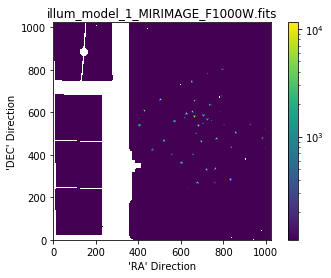

In [27]:
show_outputs(outputdir,'illum_models')

## Viewing the final detector image

The detector images are the final output of MIRISim, and have data structures and formatting consistent with what will come from MIRI itself. The data format is JWST pipeline ready.  Below an example image of the last frame of the last integration is shown. The units are <code>DN</code>.

Additionally, below the FITS header information for the SCIENCE extension is listed

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                 1032                                                  
NAXIS2  =                 1024                                                  
NAXIS3  =                   50                                                  
NAXIS4  =                    4                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
                                                                                
        Information about the coordinates in the file                           
                            

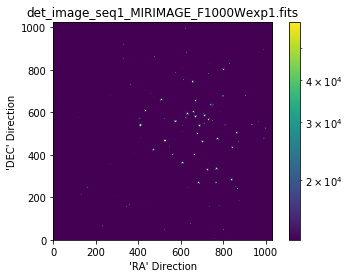

In [28]:
show_outputs(outputdir,'det_images')

infits = glob.glob('{}/det_images/*.fits'.format(outputdir))[0]
hdulist = fits.open(infits)
hdulist[1].header

## The outputs of MIRISim can now be run through the JWST pipeline see:
###  https://jwst-docs.stsci.edu/jwst-data-reduction-pipeline and https://jwst-pipeline.readthedocs.io/en/stable/